# Применение условных вероятностей в анализе данных на примере набора данных для прогнозирования диабета

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных и их описание

In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')  

print("Размерность данных:", df.shape)

Размерность данных: (100000, 9)


In [4]:
df.head()  # первые пять строк

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
print("Столбцы:", df.columns.tolist())  # список столбцов

Столбцы: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


In [6]:
df.info()  # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [34]:
feature_info = {
    'Признак': [
        'gender', 'age', 'hypertension', 'heart_disease',
        'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'
    ],
    'Тип': [
        'Категориальный', 'Числовой', 'Бинарный', 'Бинарный',
        'Категориальный', 'Числовой', 'Числовой',
        'Числовой', 'Бинарный'
    ],
    'Описание': [
        'Пол пациента (Male / Female / Other)',
        'Возраст пациента',
        'Наличие гипертонии (0 – нет, 1 – да)',
        'Наличие болезней сердца (0 – нет, 1 – да)',
        'История курения',
        'Индекс массы тела',
        'Уровень гликированного гемоглобина HbA1c',
        'Уровень глюкозы в крови',
        'Диагноз диабета (0 – нет, 1 – да)'
    ],
    'Проблемы': [
        'Редкая категория "Other"',
        '–',
        '–',
        '–',
        'Сложная структура',
        'Выбросы',
        'Выбросы',
        'Выбросы; не указано, проводилось ли натощак',
        '–'
    ]
}

df_features = pd.DataFrame(feature_info)
df_features

,Признак,Тип,Описание,Проблемы
0,gender,Категориальный,Пол пациента (Male / Female / Other),"Редкая категория ""Other"""
1,age,Числовой,Возраст пациента,–
2,hypertension,Бинарный,"Наличие гипертонии (0 – нет, 1 – да)",–
3,heart_disease,Бинарный,"Наличие болезней сердца (0 – нет, 1 – да)",–
4,smoking_history,Категориальный,История курения,Сложная структура
5,bmi,Числовой,Индекс массы тела,Выбросы
6,HbA1c_level,Числовой,Уровень гликированного гемоглобина HbA1c,Выбросы
7,blood_glucose_level,Числовой,Уровень глюкозы в крови,"Выбросы; не указано, проводилось ли натощак"
8,diabetes,Бинарный,"Диагноз диабета (0 – нет, 1 – да)",–


Интересно проанализировать долю диабетиков по полу и истории курения:

In [8]:
print("Доля диабетиков по полу и истории курения:")
pivot = pd.pivot_table(
    df,
    values='diabetes',
    index=['smoking_history'],
    columns=['gender'],
    aggfunc='mean',
    fill_value=0
)
pivot.round(4)

Доля диабетиков по полу и истории курения:


gender,Female,Male,Other
smoking_history,,,
No Info,0.0383,0.0435,0
current,0.0892,0.1175,0
ever,0.0943,0.1479,0
former,0.1359,0.2055,0
never,0.0875,0.1100,0
not current,0.1007,0.1172,0


Описание категорий истории курения:
* No Info – нет информации;
* current – курит в настоящий момент;
* ever – когда-либо курил;
* former – бывший курильщик;
* never – никогда не курил;
* not current – временно не курит.

Мужчины демонстрируют более высокий риск диабета во всех категориях курения по сравнению с женщинами. Наибольшая доля – среди бывших курильщиков (20.55% у мужчин). Категория Other не содержит случаев диабета.

## Вероятности и условные вероятности

### Простые вероятности

In [9]:
# P(gender) – вероятность быть мужчиной или женщиной
for gender in df['gender'].unique():
    P_gender = (df['gender'] == gender).mean()
    print(f"P(gender = {gender}) = {P_gender:.3f}")

P(gender = Female) = 0.586
P(gender = Male) = 0.414
P(gender = Other) = 0.000


In [10]:
# P(hypertension) – вероятность быть гипертоником
P_hypertension = df['hypertension'].mean()
print(f"P(hypertension) = {P_hypertension:.3f}")

P(hypertension) = 0.075


In [11]:
# P(heart_disease) – вероятность иметь болезнь сердца
P_heart_disease = df['heart_disease'].mean()
print(f"P(heart_disease) = {P_heart_disease:.3f}")

P(heart_disease) = 0.039


In [12]:
# P(smoking) - вероятность относиться к определённой категории истории курения
for smoking in df['smoking_history'].unique():
    P_smoking = (df['smoking_history'] == smoking).mean()
    print(f"P(smoking = {smoking}) = {P_smoking:.3f}")

P(smoking = never) = 0.351
P(smoking = No Info) = 0.358
P(smoking = current) = 0.093
P(smoking = former) = 0.094
P(smoking = ever) = 0.040
P(smoking = not current) = 0.064


In [13]:
# P(diabetes) – вероятность быть диабетиком
P_diabetes = df['diabetes'].mean()
print(f"P(diabetes) = {P_diabetes:.3f}")

P(diabetes) = 0.085


### Условная вероятность $P_B(A)$

Какова вероятность быть диабетиком, если пациенту меньше 10 лет?

Формула: $$P_{\text{age\_less\_10}}(\text{diabetes})=\frac{P(\text{diabetes}\cdot \text{age\_less\_10})}{P(\text{age\_less\_10})}$$

In [14]:
# Способ 1: вручную по формуле
P_age_less_10 = (df['age'] < 10).mean()
P_diabetes_and_age_less_10 = ((df['diabetes'] == 1) & (df['age'] < 10)).mean()

P_diabetes_if_age_less_10 = P_diabetes_and_age_less_10 / P_age_less_10
print(f"P(diabetes | age_less_10), рассчитанная вручную: {P_diabetes_if_age_less_10:.3f}")

P(diabetes | age_less_10), рассчитанная вручную: 0.002


In [15]:
# Способ 2: просто отфильтровав датафрейм и посчитав среднее
age_less_10 = df[df['age'] < 10]
P_diabetes_if_age_less_10_filter = age_less_10['diabetes'].mean()
print(f"P(diabetes | age_less_10), рассчитанная через фильтр: {P_diabetes_if_age_less_10_filter:.3f}")

P(diabetes | age_less_10), рассчитанная через фильтр: 0.002


Напишем функцию определения условных вероятностей:

In [16]:
# df – датафрейм;
# condition_col – название столбца с произошедшим событием;
# condition_val – значение произошедшего события;
# target_col – название столбца с целевым событием;
# target_val – значение целевого события.

def conditional_probability(df, condition_col, condition_val, target_col, target_val=1):
    """
    Вычисляет условную вероятность
    P(target_col=target_val | condition_col=condition_val)
    """
    subset = df[df[condition_col] == condition_val]
    if len(subset) == 0:
        return 0
    return (subset[target_col] == target_val).mean()

In [54]:
print("УСЛОВНЫЕ ВЕРОЯТНОСТИ БЫТЬ ДИАБЕТИКОМ:")
print("=" * 37)

# По полу
print("\nПо полу:")
for gender in df['gender'].unique():
    prob = conditional_probability(df, 'gender', gender, 'diabetes')
    print(f"  P(diabetes | gender = {gender}) = {prob:.3f}")

# По возрасту
print("\nПо возрасту:")
# Группа 1: возраст <= 45
subset_young = df[df['age'] <= 45]
if len(subset_young) > 0:
    prob_young = subset_young['diabetes'].mean()
    print(f"  P(diabetes | age <= 45) = {prob_young:.3f}")
else:
    print("  Нет данных для возраста <= 45")

# Группа 2: возраст > 45
subset_old = df[df['age'] > 45]
if len(subset_old) > 0:
    prob_old = subset_old['diabetes'].mean()
    print(f"  P(diabetes | age > 45) = {prob_old:.3f}")
else:
    print("  Нет данных для возраста > 45")

# По наличию гипертонии
print("\nПо наличию гипертонии:")
for hypertension in sorted(df['hypertension'].unique()):
    prob = conditional_probability(df, 'hypertension', hypertension, 'diabetes')
    print(f"  P(diabetes | hypertension = {hypertension}) = {prob:.3f}")

# По наличию болезней сердца
print("\nПо наличию болезней сердца:")
for disease in sorted(df['heart_disease'].unique()):
    prob = conditional_probability(df, 'heart_disease', disease, 'diabetes')
    print(f"  P(diabetes | heart_disease = {disease}) = {prob:.3f}")

# По истории курения
print("\nПо истории курения:")
for smoking in df['smoking_history'].unique():
    prob = conditional_probability(df, 'smoking_history', smoking, 'diabetes')
    print(f"  P(diabetes | smoking_history = {smoking}) = {prob:.3f}")

# По индексу массы тела
print("\nПо индексу массы тела:")
# Группа 1: ИМТ < 18.5
subset_less = df[df['bmi'] < 18.5]
if len(subset_less) > 0:
    prob_less = subset_less['diabetes'].mean()
    print(f"  P(diabetes | bmi < 18.5) = {prob_less:.3f}")
else:
    print("  Нет данных для ИМТ < 18.5")

# Группа 2: ИМТ > 24.9
subset_greater = df[df['bmi'] > 24.9]
if len(subset_greater) > 0:
    prob_greater = subset_greater['diabetes'].mean()
    print(f"  P(diabetes | bmi > 24.9) = {prob_greater:.3f}")
else:
    print("  Нет данных для ИМТ > 24.9")

# Группа 3: ИМТ в норме
subset_normal = df[(df['bmi'] <= 24.9) & (18.5 <= df['bmi'])]
if len(subset_normal) > 0:
    prob_normal = subset_normal['diabetes'].mean()
    print(f"  P(diabetes | normal bmi) = {prob_normal:.3f}")
else:
    print("  Нет данных для нормального ИМТ")

# По уровню гликированного гемоглобина
print("\nПо уровню гликированного гемоглобина:")
# Группа 1: HbA1c < 4
subset_less = df[df['HbA1c_level'] < 4]
if len(subset_less) > 0:
    prob_less = subset_less['diabetes'].mean()
    print(f"  P(diabetes | HbA1c < 4) = {prob_less:.3f}")
else:
    print("  Нет данных для HbA1c < 4")

# Группа 2: HbA1c > 6.2
subset_greater = df[df['HbA1c_level'] > 6.2]
if len(subset_greater) > 0:
    prob_greater = subset_greater['diabetes'].mean()
    print(f"  P(diabetes | HbA1c > 6.2) = {prob_greater:.3f}")
else:
    print("  Нет данных для HbA1c > 6.2")

# Группа 3: HbA1c в норме
subset_normal = df[(df['HbA1c_level'] <= 6.2) & (4 <= df['HbA1c_level'])]
if len(subset_normal) > 0:
    prob_normal = subset_normal['diabetes'].mean()
    print(f"  P(diabetes | normal HbA1c) = {prob_normal:.3f}")
else:
    print("  Нет данных для нормального HbA1c")

# По уровню глюкозы в крови (пусть исследование проводилось натощак)
print("\nПо уровню глюкозы в крови:")
# Группа 1: glucose < 70
subset_less = df[df['blood_glucose_level'] < 70]
if len(subset_less) > 0:
    prob_less = subset_less['diabetes'].mean()
    print(f"  P(diabetes | glucose < 70) = {prob_less:.3f}")
else:
    print("  Нет данных для уровня глюкозы < 70")

# Группа 2: glucose > 110
subset_greater = df[df['blood_glucose_level'] > 110]
if len(subset_greater) > 0:
    prob_greater = subset_greater['diabetes'].mean()
    print(f"  P(diabetes | glucose > 110) = {prob_greater:.3f}")
else:
    print("  Нет данных для уровня глюкозы > 110")

# Группа 3: glucose в норме
subset_normal = df[(df['blood_glucose_level'] <= 110) & (70 <= df['blood_glucose_level'])]
if len(subset_normal) > 0:
    prob_normal = subset_normal['diabetes'].mean()
    print(f"  P(diabetes | normal glucose) = {prob_normal:.3f}")
else:
    print("  Нет данных для нормального уровня глюкозы")

УСЛОВНЫЕ ВЕРОЯТНОСТИ БЫТЬ ДИАБЕТИКОМ:

По полу:
  P(diabetes | gender = Female) = 0.076
  P(diabetes | gender = Male) = 0.097
  P(diabetes | gender = Other) = 0.000

По возрасту:
  P(diabetes | age <= 45) = 0.023
  P(diabetes | age > 45) = 0.158

По наличию гипертонии:
  P(diabetes | hypertension = 0) = 0.069
  P(diabetes | hypertension = 1) = 0.279

По наличию болезней сердца:
  P(diabetes | heart_disease = 0) = 0.075
  P(diabetes | heart_disease = 1) = 0.321

По истории курения:
  P(diabetes | smoking_history = never) = 0.095
  P(diabetes | smoking_history = No Info) = 0.041
  P(diabetes | smoking_history = current) = 0.102
  P(diabetes | smoking_history = former) = 0.170
  P(diabetes | smoking_history = ever) = 0.118
  P(diabetes | smoking_history = not current) = 0.107

По индексу массы тела:
  P(diabetes | bmi < 18.5) = 0.008
  P(diabetes | bmi > 24.9) = 0.109
  P(diabetes | normal bmi) = 0.038

По уровню гликированного гемоглобина:
  P(diabetes | HbA1c < 4) = 0.000
  P(diabetes |

**Вывод:** условная вероятность необходима для понимания зависимостей между переменными. Она позволяет ответить на вопрос: "Какова вероятность события A, если мы знаем, что произошло событие B?"

В моём примере – вероятность быть диабетиком при разных условиях – мы видим, как сильно меняется риск в зависимости от факторов.

## Формула полной вероятности

Мы знаем вероятность быть диабетиком для каждой категории признака "история курения". Как, используя эту информацию, найти общую вероятность быть диабетиком $P(\text{diabetes})$?

**Формула полной вероятности:**
$$
P(A) = \sum P_{B_i}(A) \cdot P(B_i), \text{ где } B_i \text{ образуют полную группу несовместных событий.}
$$

В моём случае:  
$$
\begin{align*}
\{ B_1, B_2, B_3, B_4, B_5, B_6 \} = &\ \{ \text{smoking\_history} = \text{never}, \text{smoking\_history} = \text{No Info},\\
&\ \text{smoking\_history} = \text{current}, \text{smoking\_history} = \text{former},\\
&\ \text{smoking\_history} = \text{ever},\text{smoking\_history} = \text{not current} \}
\end{align*}
$$

$$
\begin{align*}
P(\text{diabetes}) = &\ P(\text{diabetes}|\text{smoking\_history} = \text{never}) \cdot P(\text{smoking\_history} = \text{never}) +\\
+ &\ P(\text{diabetes}|\text{smoking\_history} = \text{No Info}) \cdot P(\text{smoking\_history} = \text{No Info}) +\\
+ &\ P(\text{diabetes}|\text{smoking\_history} = \text{current}) \cdot P(\text{smoking\_history} = \text{current}) +\\
+ &\ P(\text{diabetes}|\text{smoking\_history} = \text{former}) \cdot P(\text{smoking\_history} = \text{former}) +\\
+ &\ P(\text{diabetes}|\text{smoking\_history} = \text{ever}) \cdot P(\text{smoking\_history} = \text{ever}) +\\
+ &\ P(\text{diabetes}|\text{smoking\_history} = \text{not current}) \cdot P(\text{smoking\_history} = \text{not current}) 
\end{align*}
$$

In [42]:
print("ФОРМУЛА ПОЛНОЙ ВЕРОЯТНОСТИ:")
print("P(diabetes) = Σ P(diabetes | smoking_history = i) * P(smoking_history = i)")
print("=" * 74)

total_prob = 0
prob_details = []

for smoking in sorted(df['smoking_history'].unique()):
    # P(smoking_history = i)
    P_smoking = (df['smoking_history'] == smoking).mean()
    # P(diabetes | smoking_history = i)
    P_diabetes_given_smoking = conditional_probability(df, 'smoking_history', smoking, 'diabetes')

    # Вклад этого класса
    contribution = P_diabetes_given_smoking * P_smoking
    total_prob += contribution

    prob_details.append({
        'smoking_history': smoking,
        'P(smoking_history)': P_smoking,
        'P(diabetes | smoking_history)': P_diabetes_given_smoking,
        'Вклад': contribution
    })

prob_df = pd.DataFrame(prob_details)
print(prob_df.round(3))

print(f"\nОбщая вероятность быть диабетиком, рассчитанная по формуле полной вероятности: {total_prob:.3f}")
print(f"Общая вероятность быть диабетиком, рассчитанная напрямую из данных: {df['diabetes'].mean():.3f}")

ФОРМУЛА ПОЛНОЙ ВЕРОЯТНОСТИ:
P(diabetes) = Σ P(diabetes | smoking_history = i) * P(smoking_history = i)
  smoking_history  P(smoking_history)  P(diabetes | smoking_history)  Вклад
0         No Info               0.358                          0.041  0.015
1         current               0.093                          0.102  0.009
2            ever               0.040                          0.118  0.005
3          former               0.094                          0.170  0.016
4           never               0.351                          0.095  0.033
5     not current               0.064                          0.107  0.007

Общая вероятность быть диабетиком, рассчитанная по формуле полной вероятности: 0.085
Общая вероятность быть диабетиком, рассчитанная напрямую из данных: 0.085


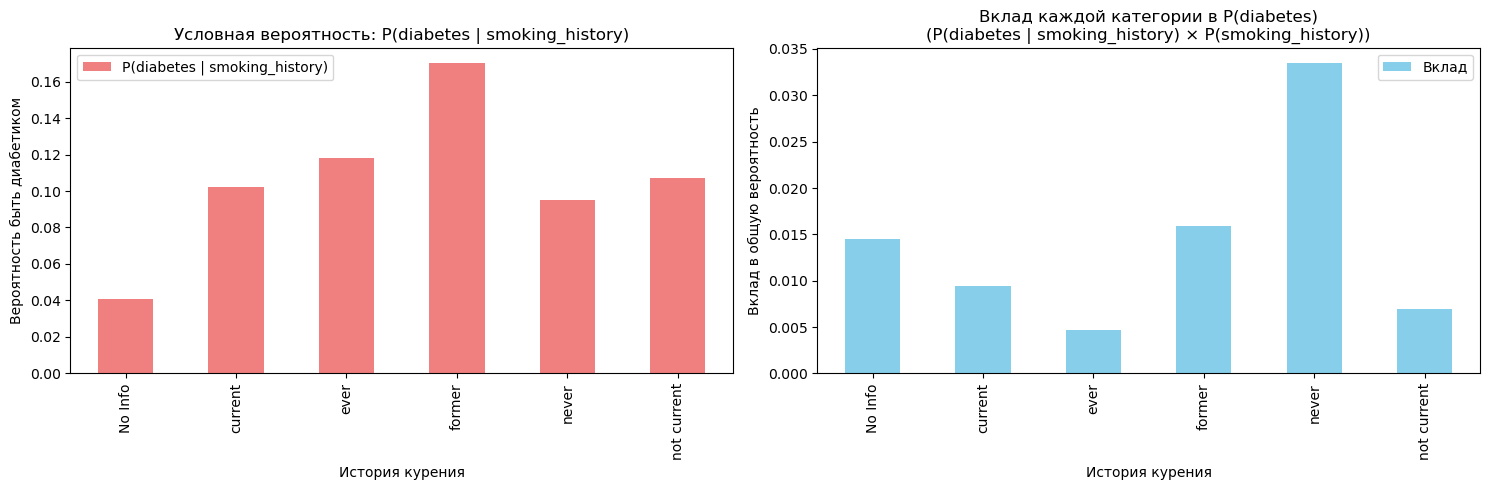

In [43]:
# Визуализируем вклад классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Левая часть: P(diabetes | smoking_history)
prob_df.plot(x='smoking_history', y='P(diabetes | smoking_history)', kind='bar', ax=ax1, color='lightcoral')
ax1.set_title('Условная вероятность: P(diabetes | smoking_history)')
ax1.set_ylabel('Вероятность быть диабетиком')
ax1.set_xlabel('История курения')

# Правая часть: вклад в общую вероятность
prob_df.plot(x='smoking_history', y='Вклад', kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Вклад каждой категории в P(diabetes)\n(P(diabetes | smoking_history) × P(smoking_history))')
ax2.set_ylabel('Вклад в общую вероятность')
ax2.set_xlabel('История курения')

plt.tight_layout()
plt.show()

**Вывод:** бывшие курильщики имеют наибольший риск диабета, что может указывать на то, что курение оставляет долгосрочные последствия или что люди бросают курить уже при наличии хронических заболеваний.

Формула полной вероятности позволяет не просто знать, что происходит в категориях, а понять, как эти категории вместе формируют общий результат.

## Формула Байеса

Мы видим пациента с диабетом. Никакой информации о нём у нас нет, но мы хотим понять, из какой он, скорее всего, категории признака "история курения". Другими словами, мы хотим найти $P_{\text{diabetes}}(\text{smoking\_history})$.

Теорема Байеса позволяет это найти:
$$
P_B(A) = \frac{P(A) \cdot P_A(B)}{P(B)}
$$

В моём случае:
- $A$: $\text{smoking\_history} = i$;
- $B$: $\text{diabetes} = 1$.

Тогда:
$$
P_{\text{diabetes}}(\text{smoking\_history} = i) = \frac{P(\text{smoking\_history} = i) \cdot P_{\text{smoking\_history} = i}(diabetes)}{P(diabetes)}
$$

In [51]:
print("ТЕОРЕМА БАЙЕСА:")
print("P(smoking_history | diabetes) = [P(diabetes | smoking_history) × P(smoking_history)] / P(diabetes)")
print("=" * 98)

# P(diabetes) - знаменатель
P_d = df['diabetes'].mean()

bayes_results = []

for smoking in sorted(df['smoking_history'].unique()):
    # P(smoking_history) – априорная вероятность
    P_A = (df['smoking_history'] == smoking).mean()
    # P(diabetes | smoking_history) – правдоподобие
    P_B_given_A = conditional_probability(df, 'smoking_history', smoking, 'diabetes')

    # Применяем теорему Байеса
    P_A_given_B = (P_B_given_A * P_A) / P_d

    bayes_results.append({
        'smoking_history': smoking,
        'P(smoking_history)': P_A,
        'P(diabetes | s_h)': P_B_given_A,
        'P(s_h | diabetes)': P_A_given_B
    })

bayes_df = pd.DataFrame(bayes_results)
print("Результаты применения теоремы Байеса:")
print(bayes_df.round(3))

ТЕОРЕМА БАЙЕСА:
P(smoking_history | diabetes) = [P(diabetes | smoking_history) × P(smoking_history)] / P(diabetes)
Результаты применения теоремы Байеса:
  smoking_history  P(smoking_history)  P(diabetes | s_h)  P(s_h | diabetes)
0         No Info               0.358              0.041              0.171
1         current               0.093              0.102              0.112
2            ever               0.040              0.118              0.056
3          former               0.094              0.170              0.187
4           never               0.351              0.095              0.394
5     not current               0.064              0.107              0.081


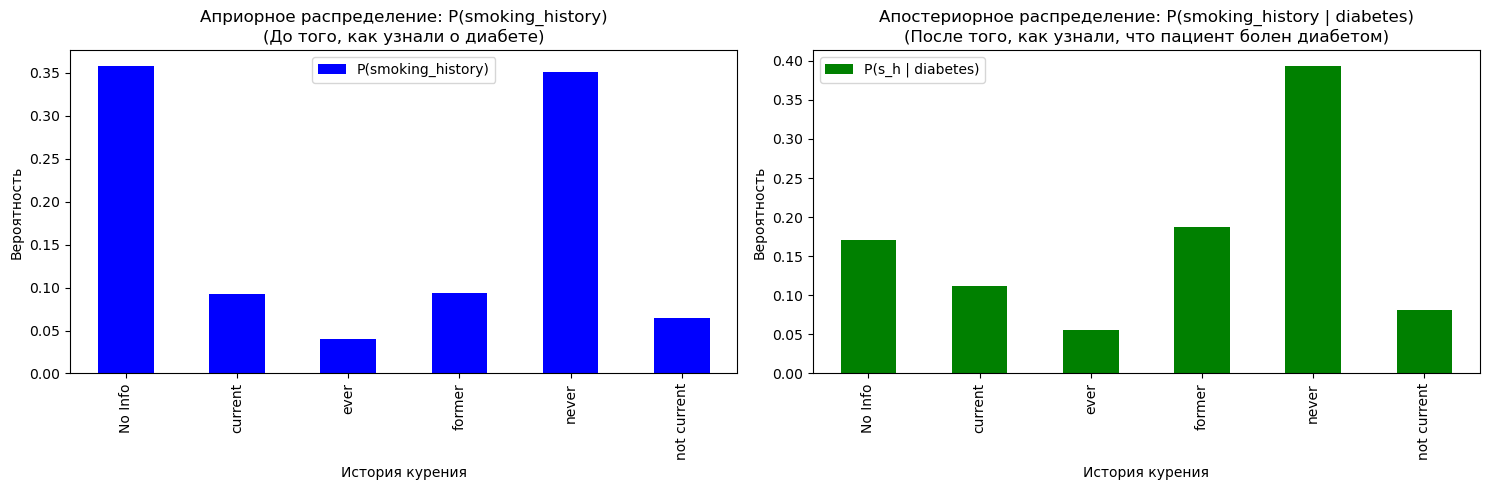

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Априорное распределение
bayes_df.plot(x='smoking_history', y='P(smoking_history)', kind='bar', ax=ax1, color='blue')
ax1.set_title('Априорное распределение: P(smoking_history)\n(До того, как узнали о диабете)')
ax1.set_ylabel('Вероятность')
ax1.set_xlabel('История курения')

# Апостериорное распределение
bayes_df.plot(x='smoking_history', y='P(s_h | diabetes)', kind='bar', ax=ax2, color='green')
ax2.set_title('Апостериорное распределение: P(smoking_history | diabetes)\n(После того, как узнали, что пациент болен диабетом)')
ax2.set_ylabel('Вероятность')
ax2.set_xlabel('История курения')

plt.tight_layout()
plt.show()

**Вывод:** большинство пациентов – некурящие или у которых нет данных. Это картина до получения дополнительной информации.

После получения информации о том, что пациент болен диабетом, даже несмотря на то, что бывшие курильщики имеют высокий риск диабета (как мы видели ранее при рассмотрении условной вероятности), в общей картине большинство диабетиков некурящие. Это происходит потому, что их доля очень велика, следовательно, они доминируют и в группе больных.

При диагностике важно понимать не только риски, но и кто чаще встречается. Например, если 80% населения – некурящие, то и среди больных их будет больше, даже если риск ниже.